In [219]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing Data

In [220]:
data = pd.read_csv("../data/processed/weatherQN_2021_2025_processed.csv", parse_dates=["time"])

data.head()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9,1.0
1,2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1,1.0
2,2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7,1.0
3,2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4,1.0
4,2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4,1.0


In [221]:
data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data["day_of_week"] = data['time'].dt.dayofweek
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data.drop(columns='time', inplace=True)

In [222]:
data.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,hour,day,day_of_week,month,year
0,20.0,17.4,85.0,0.0,350.0,20.2,1017.9,1.0,0,2,5,1,2021
1,20.0,17.8,87.0,0.2,343.0,17.6,1016.1,1.0,3,2,5,1,2021
2,19.8,17.8,88.0,0.1,339.0,17.6,1016.7,1.0,6,2,5,1,2021
3,20.2,18.3,89.0,0.2,347.0,18.7,1018.4,1.0,9,2,5,1,2021
4,22.0,18.0,78.0,0.1,3.0,28.4,1016.4,1.0,12,2,5,1,2021


In [223]:
X = data.drop(columns=['coco']) 
y = data['coco'] 

In [224]:
y.unique()

array([ 1.,  3.,  2.,  7., 17.,  8.,  9., 18.,  5.])

In [225]:
unique_labels = sorted(y.unique())  
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
y = y.map(label_mapping)

In [226]:
y.unique()

array([0, 2, 1, 4, 7, 5, 6, 8, 3], dtype=int64)

coco
0    4736
1     787
2    4302
3      85
4     524
5     628
6     391
7     508
8      74
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_36340\1107155487.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


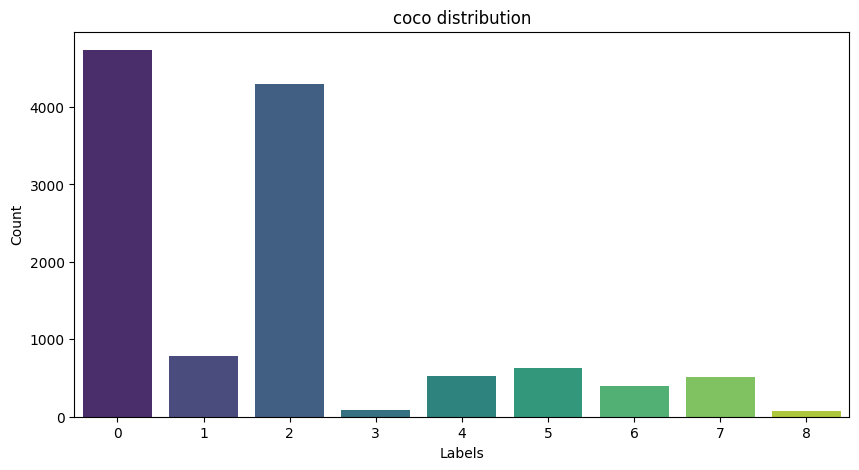

In [227]:
label_counts = y.value_counts().sort_index()
print(label_counts)

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("coco distribution")
plt.show()

In [228]:
scaler_path = '../models/scalers/scaler.pkl'
scaler = joblib.load(scaler_path)

In [229]:
X_scaled = scaler.fit_transform(X)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Building Model

In [231]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

sample_weight = np.array([class_weight_dict[label] for label in y_train])

sample_weight

array([0.28233776, 0.28233776, 2.55316892, ..., 0.28233776, 0.28233776,
       0.28233776])

In [232]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    max_depth=5,
    learning_rate=0.01,
    n_estimators=200,
    device='cuda',
    random_state=42
)


In [233]:
model.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

In [234]:
y_pred = model.predict(X_test)

In [235]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7678
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       947
           1       0.21      0.51      0.30       157
           2       0.84      0.68      0.75       860
           3       0.25      0.82      0.39        17
           4       0.66      0.82      0.73       105
           5       0.84      0.93      0.88       126
           6       0.93      0.83      0.88        78
           7       0.56      0.35      0.43       102
           8       0.50      0.67      0.57        15

    accuracy                           0.77      2407
   macro avg       0.64      0.72      0.65      2407
weighted avg       0.84      0.77      0.79      2407



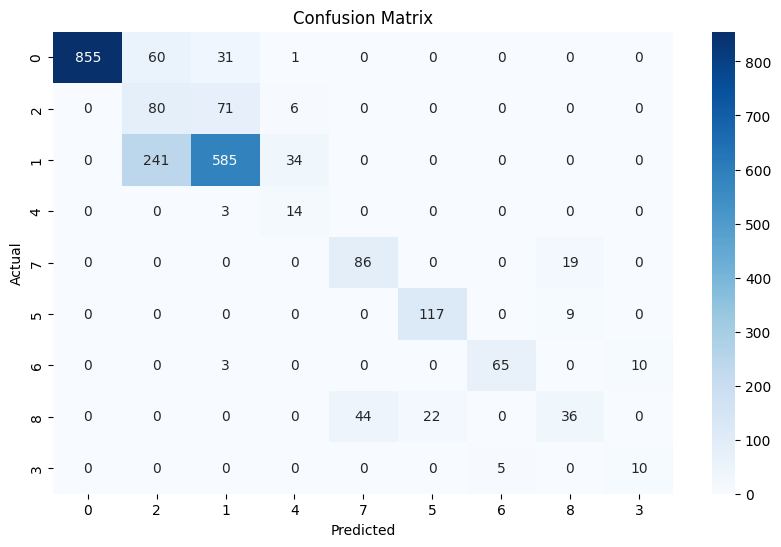

In [236]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [238]:
model.save_model('../models/best_cls_model/xgb_model.json')